In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import pysentani as sti

In [2]:
survey = pd.read_excel('../data-anonymous/sentani-merged-cleaned-anonymous-2014-11-29.xlsx')
survey['access_type'] = sti.access_type(survey)

In [3]:
response_count = survey[['app_buy_if_elec_imm/rice_cooker',
                         'app_buy_if_elec_imm/TV',
                         'app_buy_if_elec_imm/fridge',
                         'app_buy_if_elec_imm/fan',
                         'app_buy_if_elec_imm/lighting',
                         'app_buy_if_elec_imm/radio',
                         'access_type',]]


In [4]:
# showing response count for each access type. Categories are uniform by access type response.
# somehow a PLN_grid response snuck in. Analysis will be conducted on no_access only.
response_count.groupby('access_type').count()

,app_buy_if_elec_imm/rice_cooker,app_buy_if_elec_imm/TV,app_buy_if_elec_imm/fridge,app_buy_if_elec_imm/fan,app_buy_if_elec_imm/lighting,app_buy_if_elec_imm/radio
access_type,,,,,,
PLN_grid,1,1,1,1,1,1
PLN_microgrid,0,0,0,0,0,0
community_microgrid,2,2,2,2,2,2
no_access,59,59,59,59,59,59


In [5]:
survey = survey[['app_now/rice_cooker',
                 'app_now/TV',
                 'app_now/fridge',
                 'app_now/fan',
                 'app_now/lighting',
                 'app_now/radio',
                 'app_buy_if_elec_imm/rice_cooker',
                 'app_buy_if_elec_imm/TV',
                 'app_buy_if_elec_imm/fridge',
                 'app_buy_if_elec_imm/fan',
                 'app_buy_if_elec_imm/lighting',
                 'app_buy_if_elec_imm/radio',
                 'access_type']]
survey = survey.dropna()
survey = survey[survey['access_type'] == 'no_access']

In [6]:
def willing_to_buy(row, now=None, buy=None):
    if row[now]==1:
        # we return zero in the case where we want to determine the latent demand
        #return np.nan
        return 0
    if row[now]==0 and row[buy]==0:
        return 0
    if row[now]==0 and row[buy]==1:
        return 1
    
def calc_willingness(survey, appliance):
    app_now_appliance = 'app_now/' + appliance
    app_buy_appliance = 'app_buy_if_elec_imm/' + appliance
    # when we average this, do we exclude the folks with the appliance?
    #survey['wb/' + appliance] = ~survey[app_now_appliance].astype(bool) & survey[app_buy_appliance].astype(bool)
    survey['wb/' + appliance] = survey.apply(willing_to_buy, 
                                axis=1, 
                                now=app_now_appliance,
                                buy=app_buy_appliance)
    
    
appliance_list = ['TV', 'lighting', 'radio', 'rice_cooker', 'fridge', 'fan' ]

# Creating variable with for loop adding each from appliance_list to calc_willingess function
WBlist = []
for appliance in appliance_list:
    calc_willingness(survey, appliance)
    WBlist.append('wb/' + appliance)

In [7]:
app_now = survey[['app_now/TV',
                  'app_now/lighting',
                  'app_now/radio',
                  'app_now/fridge',
                  'app_now/rice_cooker',
                  'app_now/fan',
                  'access_type']]

app_buy = survey[['app_buy_if_elec_imm/TV',
                  'app_buy_if_elec_imm/lighting',
                  'app_buy_if_elec_imm/radio',
                  'app_buy_if_elec_imm/fridge',
                  'app_buy_if_elec_imm/rice_cooker',
                  'app_buy_if_elec_imm/fan',
                  'access_type',]]

wb      = survey[['wb/TV',
                  'wb/lighting',
                  'wb/radio',
                  'wb/fridge',
                  'wb/rice_cooker',
                  'wb/fan',
                  'access_type',]]

app_now.columns = [col.replace('app_now/', '') for col in app_now.columns]
app_buy.columns = [col.replace('app_buy_if_elec_imm/', '') for col in app_buy.columns]
wb.columns = [col.replace('wb/', '') for col in wb.columns]

In [8]:
app_now_mean = app_now.groupby('access_type').mean().stack()
app_buy_mean = wb.groupby('access_type').mean().stack()

future_electrification = app_buy_mean + app_now_mean 
fe_tidy = future_electrification.reset_index()
fe_tidy.rename(columns={'level_1':'Appliance', 0:'Projected Ownership'},
              inplace=True)
fe_tidy

,access_type,Appliance,Projected Ownership
0,no_access,TV,0.846154
1,no_access,lighting,0.743590
2,no_access,radio,0.461538
3,no_access,fridge,0.410256
4,no_access,rice_cooker,0.333333
5,no_access,fan,0.230769


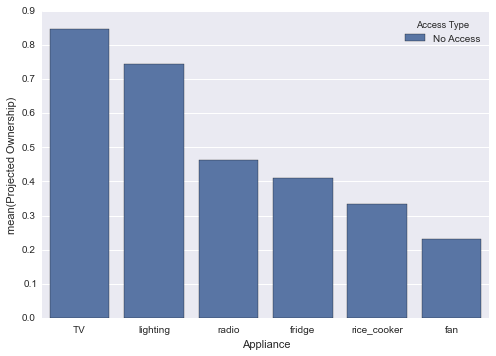

In [9]:
fe_tidy.replace(to_replace = {'access_type': {'PLN_grid': 'PLN Grid',
                                             'community_microgrid': 'Community Microgrid',
                                             'PLN_microgrid': 'PLN Microgrid',
                                             'no_access': 'No Access'}},inplace = True)
fe_tidy.rename(columns={'access_type':'Access Type'}, inplace=True)
sns.barplot(hue='Access Type', y='Projected Ownership', x='Appliance', data=fe_tidy)
plt.savefig('post-electrification-ownership.pdf')

In [10]:
app_now_mean = app_now.groupby('access_type').mean().stack()
app_now_mean

access_type             
no_access    TV             0.666667
             lighting       0.743590
             radio          0.358974
             fridge         0.000000
             rice_cooker    0.025641
             fan            0.051282
dtype: float64

In [11]:
app_buy_mean = wb.groupby('access_type').mean().stack()
app_buy_mean

access_type             
no_access    TV             0.179487
             lighting       0.000000
             radio          0.102564
             fridge         0.410256
             rice_cooker    0.307692
             fan            0.179487
dtype: float64